In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

#For editable text. Except latex text is still shapes sadly
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sns.set_style("whitegrid")
font = {'size' : 6}
lines = {'linewidth' : 0.5}
fig = {'figsize' : (2.5, 1.5)}
mpl.rc('font', **font)
mpl.rc('lines', **lines)
mpl.rc('figure', **fig)
#Set style
sns.set(style="whitegrid", palette="pastel", color_codes=True)

from matplotlib.colors import ListedColormap

from scipy.stats import mannwhitneyu
import statsmodels.stats.multitest as smt # for BH multiple hypothesis testing

np.random.seed(31)

/Users/kayaneh/anaconda3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.DataFrame()
sourceDataPath = "/Users/kayaneh/Documents/deconvolution/aip/source_data/fig2_sourceData.xlsx"
df.to_excel(sourceDataPath)

In [3]:
figSavePath = "/Users/kayaneh/Documents/deconvolution/figures/full_figure/maintext_revision1/"

figEnd = "_09232021.pdf"

In [4]:
def save_figure_pdf(fig, path_to_save):
	'''
	Utility fxn to save a figure without having to retype all the required options.
	Input:
		fig - a matplotlib.pyplot.figure instance with the figure you'd like to save
		path_to_save - the path you'd like to save the figure to
	Returns: Nothing but there should now be a pdf version in 300 dpi with a transparent bkg at path_to_save
	'''
	fig.savefig(path_to_save, dpi = 300, bbox_inches = 'tight', transparent = True)

In [5]:
# import the counts table that are the CPM-TMM values


cts = pd.read_csv("~/Documents/deconvolution/nafld/remapped_unstranded/nafld-CPMTMM_serumVol_09052021.csv",
                index_col = [0,1])


# import metadata and just do the good ones based on what Shu said
metadat = pd.read_csv("~/Documents/deconvolution/nafld/SraRunTable-2.txt",
                     index_col = 0)


metadat = metadat.loc[cts.columns.tolist()]
print(metadat.shape)

(359, 31)


In [6]:
shuMeta = pd.read_excel("~/Documents/deconvolution/nafld/Liver-fibrosis clinical information_diabetes.xlsx",
                         index_col = 0)

# resolve the extraneous spaces in the disease labels of shuMeta
shuMeta["disease"] = [i.split(" ")[0] for i in shuMeta["disease"]]

In [7]:
# sort metadat by sample names and get shu meta in the same order
metadat.sort_values(by = "Sample Name", inplace = True)

shuMeta = shuMeta.loc[metadat["Sample Name"].values]

# good stuff, they agree
print(np.unique(shuMeta.index == metadat["Sample Name"]))

# add the SRR codes to shuMeta
shuMeta["SRR"] = metadat.index.tolist()
shuMeta["Biolog Rep"] = [i.split("-")[0] for i in shuMeta.index.tolist()]

# make it like the original SRA code and set the index on SRA codes
shuMeta.set_index(["SRR"], inplace = True)

[ True]


In [8]:
# subset the metadata to only the samples passing QC
shuMeta = shuMeta.loc[cts.columns]

In [9]:
# get the centers
print(np.unique(shuMeta["Center"]))

print(np.unique(shuMeta[shuMeta["Center"] == "University of Florida"]['disease']))


print(np.unique(shuMeta[shuMeta["Center"] == "San Diego Blood Bank"]['disease']))

# NAFLD and NASH
print(np.unique(shuMeta[shuMeta["Center"] == "Indiana University"]['disease']))

['Indiana University' 'San Diego Blood Bank' 'University of Florida']
['NAFLD' 'NASH']
['Healthy']
['NAFLD' 'NASH']


good stuff, looks like disease status is not totally conflated with batch. 
I'll zero center and do the comparison since the healthy came from a different center.

# do signature scoring for liver and adipocyte

In [10]:
# add a column to metadata stripping the technical replicate ID
# so that all biological replicates are grouped together

# segment metadat to those samples passing QC
relMetadat = shuMeta.loc[cts.columns.tolist()]


relMetadat = relMetadat.set_index(["Biolog Rep"])

#relMetadat = shuMeta.set_index(["Biolog Rep"])
relMetadat = relMetadat[~relMetadat.index.duplicated(keep='first')]
print(relMetadat.shape)


relMetadat = relMetadat[["*age", "*sex", "disease", "disease_stage", "Diabetes", "Center"]]

(225, 12)


In [11]:
allReplicates = {}
for samp in np.unique(shuMeta["Biolog Rep"]):
    # pull the SRR codes corresponding to a given sample ID
    thisSampSRR = shuMeta[shuMeta["Biolog Rep"] == samp].index.tolist()
    allReplicates[samp] = thisSampSRR

In [12]:
# get the average expression of the genes
biologRepGeneAvgs = pd.DataFrame()

for biologRep in allReplicates:
    technicalReplicates = allReplicates[biologRep]
    avgGeneCtsAcrossReps = cts[technicalReplicates].mean(axis = 1).to_frame()
    avgGeneCtsAcrossReps.columns = [biologRep]
    biologRepGeneAvgs = pd.concat([avgGeneCtsAcrossReps, biologRepGeneAvgs], 
                                  axis = 1)

In [13]:
liverSigs = pd.read_csv("~/Documents/deconvolution/livertox/liversig/gini6_perCluster_hepatocyte_12052020.csv",
                        sep = ",", index_col = 0)
kidneySigs = pd.read_csv("~/Documents/deconvolution/fig3_git/gini6_perCluster_kidney_12072020.csv",
                        index_col = 0)

In [14]:
liverDict = {}
for celltype in liverSigs:
    genes = liverSigs[celltype].dropna().index.tolist()
    name = celltype.split("-")[0]
    liverDict[name] = genes
    
for celltype in kidneySigs:
    genes = kidneySigs[celltype].dropna().index.tolist()
    name = celltype.split("-")[0]
    liverDict[name] = genes
    

In [15]:
# returns df cellTypeSigs, which is a samples x cell types DF
def sigScore(df, markerDict):
    cellTypeSigs = pd.DataFrame()
    for ct in markerDict:
        cellTypeGenes = markerDict[ct]
        res = df.loc[df.index.get_level_values(1).isin(cellTypeGenes)].sum(axis = 0)
        cellTypeSigs[ct] = res
    return(cellTypeSigs)

In [16]:
"""cellTypeSigs = pd.DataFrame()
for ct in liverDict:
    cellTypeGenes = liverDict[ct]
    res = zeroCenter.loc[zeroCenter.index.get_level_values(1).isin(cellTypeGenes)].sum(axis = 0)
    cellTypeSigs[ct] = res"""

'cellTypeSigs = pd.DataFrame()\nfor ct in liverDict:\n    cellTypeGenes = liverDict[ct]\n    res = zeroCenter.loc[zeroCenter.index.get_level_values(1).isin(cellTypeGenes)].sum(axis = 0)\n    cellTypeSigs[ct] = res'

In [17]:
# let's see how we do better than random
biologRepGeneAvgs = biologRepGeneAvgs.loc[[i for i in biologRepGeneAvgs.index if "ERCC" not in i[0]]]

# drop the not aligned at the bottom
biologRepGeneAvgs = biologRepGeneAvgs.iloc[:-6,:]

# drop all genes that are zero
biologRepGeneAvgs = biologRepGeneAvgs[biologRepGeneAvgs.any(axis = 1)]

In [18]:
biologRepGeneAvgs.shape

(29947, 225)

In [19]:
# get the number of observations per disease
diseases, numObs = np.unique(relMetadat["disease"], return_counts = True)

In [20]:
print("diseases: ", diseases, " numObs ", numObs)

diseases:  ['Healthy' 'NAFLD' 'NASH']  numObs  [ 16  46 163]


# PERFORM THE SIGNATURE SCORING

In [21]:
logCts = np.log(biologRepGeneAvgs + 1)

In [22]:
hepCIS = sigScore(logCts, liverDict)

In [23]:
hepCIS = hepCIS.join(relMetadat, rsuffix = "Biolog Rep")

In [24]:
meltHepCIS = pd.melt(hepCIS, value_vars = hepCIS.columns[:-relMetadat.shape[1]],
       id_vars = hepCIS.columns[-relMetadat.shape[1]:])

In [25]:
hepMelt = meltHepCIS[meltHepCIS["variable"] == "Hepatocytes"]

In [26]:
hepMelt

,*age,*sex,disease,disease_stage,Diabetes,Center,variable,value
225,82,Male,Healthy,NaN,NaN,San Diego Blood Bank,Hepatocytes,224.995240
226,61,Male,Healthy,NaN,NaN,San Diego Blood Bank,Hepatocytes,146.591380
227,36,Female,Healthy,NaN,NaN,San Diego Blood Bank,Hepatocytes,135.508784
228,35,Female,NASH,F3,Yes,Indiana University,Hepatocytes,120.569800
229,62,Female,NASH,F4,Yes,Indiana University,Hepatocytes,170.644270
...,...,...,...,...,...,...,...,...
445,66,Female,NASH,F2,No,University of Florida,Hepatocytes,134.785551
446,58,Male,NASH,F4,No,University of Florida,Hepatocytes,208.738299
447,52,Female,NAFLD,F0,No,University of Florida,Hepatocytes,165.853113
448,50,Male,NASH,F4,No,University of Florida,Hepatocytes,251.831700


In [27]:
center_pal = {}
center_pal["San Diego Blood Bank"] = "#5C80BC"
center_pal["University of Florida"] = "#FF729F"
center_pal["Indiana University"] = "#0BC9CD"

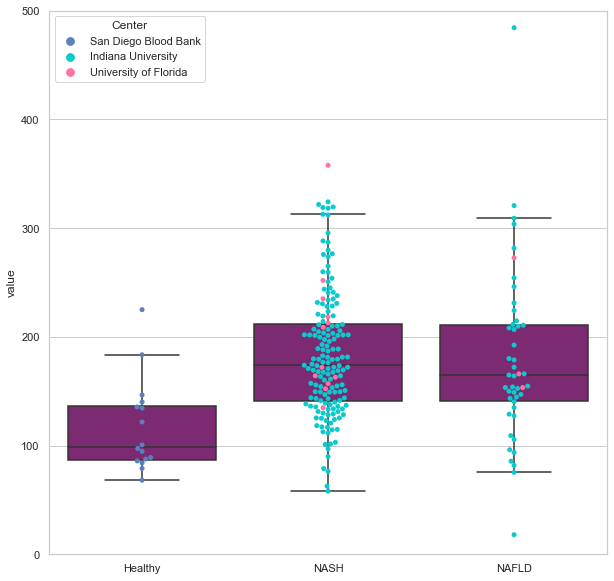

In [28]:
plt.figure(figsize = (10, 10))
sns.boxplot(x = "disease", y = "value", 
            fliersize = 0,
            data = hepMelt, color = "#8A1C7C")
sns.swarmplot(x = "disease", y = "value", data = hepMelt,
             hue = "Center", palette = center_pal, size = 5)
plt.ylim((0, 500))
plt.yticks(np.arange(0, 501, 100))
plt.xlabel("")
save_figure_pdf(plt, "nashNAFLDSigScore" + figEnd)

In [29]:
with pd.ExcelWriter(sourceDataPath, mode = 'a') as writer:
            hepMelt[["Center", "variable", 'value']].to_excel(writer, sheet_name = 'NASHNAFLD', engine = 'xlsxwriter')

In [30]:
nashCts = hepMelt[hepMelt["disease"] == "NASH"]["value"].values.tolist()

In [31]:
nafldCts = hepMelt[hepMelt["disease"] == "NAFLD"]["value"].values.tolist()

In [32]:
ctrlCts = hepMelt[hepMelt["disease"] == "Healthy"]["value"].values.tolist()

In [33]:
actualCTRLNAFLD_u, actualCTRLNAFLD_p  = mannwhitneyu(ctrlCts, nafldCts, alternative = "less")

In [34]:
actualCTRLNASH_u, actualCTRLNASH_p = mannwhitneyu(ctrlCts, nashCts, alternative = "less")

In [35]:
actualNASHNAFLD_u, actualNASHNAFLD_p = mannwhitneyu(nafldCts, nashCts, alternative = "two-sided")

In [36]:
print(actualCTRLNAFLD_u, actualCTRLNAFLD_p)

155.0 0.0003147929602541436


In [37]:
print(actualCTRLNASH_u, actualCTRLNASH_p)

427.0 4.6786045013255085e-06


In [38]:
print(actualNASHNAFLD_u, actualNASHNAFLD_p)

3483.0 0.4635905378543477


# now run respective permutation tests

In [39]:
np.random.seed(10)

pvals_ctrlNAFLD = []
pvals_ctrlNASH = []
pvals_nashNAFLD = []


u_ctrlNAFLD = []
u_ctrlNASH = []
ustat_nashNAFLD = []

for i in range(10000):
    newLabels = np.random.permutation(hepMelt["disease"])
    hepMelt['shuffled'] = newLabels
    
    
    nash = hepMelt[hepMelt['shuffled'] == "NASH"]['value'].values.tolist()
    nafld = hepMelt[hepMelt['shuffled'] == "NAFLD"]["value"].values.tolist()
    healthy = hepMelt[hepMelt['shuffled'] == "Healthy"]["value"].values.tolist()
    
    u_healthyNAFLD, p_healthyNAFLD = mannwhitneyu(healthy, nafld, alternative = "less")
    u_healthyNASH, p_healthyNASH = mannwhitneyu(healthy, nash, alternative = "less")
    u_nashNAFLD, p_nashNAFLD = mannwhitneyu(nash, nafld, alternative = "two-sided")
    
    u_ctrlNAFLD += [u_healthyNAFLD]
    u_ctrlNASH += [u_healthyNASH]
    ustat_nashNAFLD += [u_nashNAFLD]
    
    pvals_ctrlNAFLD += [p_healthyNAFLD]
    pvals_ctrlNASH += [p_healthyNASH]
    pvals_nashNAFLD += [p_nashNAFLD]
   
    

/Users/kayaneh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


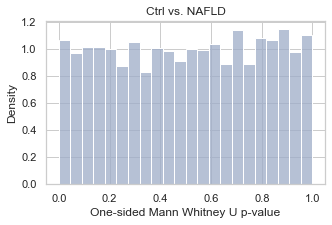

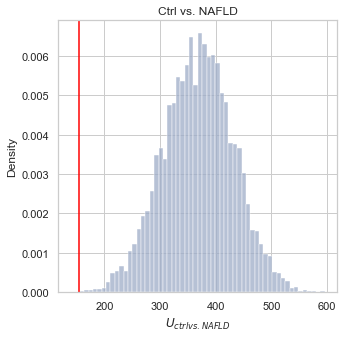

In [40]:
plt.figure(figsize = (5, 3))
sns.histplot(pvals_ctrlNAFLD, stat = "density", color = "#9EADC8")
plt.title("Ctrl vs. NAFLD")
plt.xlabel("One-sided Mann Whitney U p-value")
save_figure_pdf(plt, 'ctrlNAFLD_nullDistribution' + figEnd)


actualDifference =  actualCTRLNAFLD_u

plt.figure(figsize = (5, 5))
sns.histplot(u_ctrlNAFLD, stat = "density", color = "#9EADC8")
plt.title("Ctrl vs. NAFLD")
plt.xlabel(r'$U_{ctrl vs. NAFLD}$')
plt.axvline(actualDifference, 0, 2, color = "red")
save_figure_pdf(plt, 'ctrlNAFLD_pValDistribution' + figEnd)

In [41]:
actualDifference

155.0

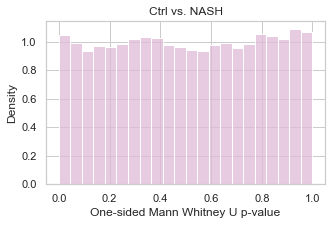

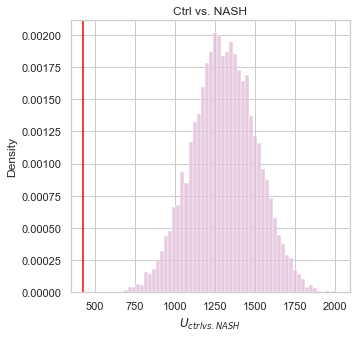

In [42]:
plt.figure(figsize = (5, 3))
sns.histplot(pvals_ctrlNASH, stat = "density", color = "#E0BAD7")
plt.title("Ctrl vs. NASH")
plt.xlabel("One-sided Mann Whitney U p-value")
save_figure_pdf(plt, 'ctrlNASH_nullDistribution' + figEnd)

actualDifference = actualCTRLNASH_u

plt.figure(figsize = (5, 5))
sns.histplot(u_ctrlNASH, stat = "density", color = "#E0BAD7")
plt.title("Ctrl vs. NASH")
plt.xlabel(r'$U_{ctrl vs. NASH}$')
plt.axvline(actualDifference, 0, 2, color = "red")
save_figure_pdf(plt, 'ctrlNASH_pValDistribution' + figEnd)

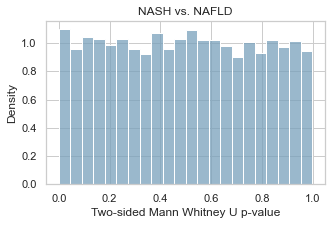

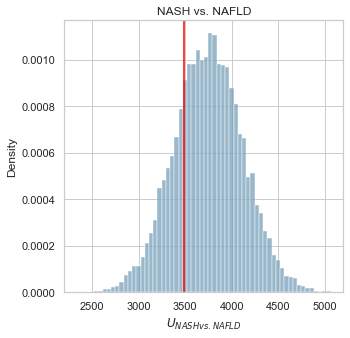

In [43]:
plt.figure(figsize = (5, 3))
sns.histplot(pvals_nashNAFLD, stat = "density", color = "#78A1BB")
plt.title("NASH vs. NAFLD")
plt.xlabel("Two-sided Mann Whitney U p-value")
save_figure_pdf(plt, figSavePath + 'nashNAFLD_nullDistribution' + figEnd)

actualDifference =  actualNASHNAFLD_u

plt.figure(figsize = (5, 5))
sns.histplot(ustat_nashNAFLD, stat = "density", color = "#78A1BB")
plt.title("NASH vs. NAFLD")
plt.xlabel(r'$U_{NASH vs. NAFLD}$')
plt.axvline(actualDifference, 0, 2, color = "red")
save_figure_pdf(plt, 'nashNAFLD_pValDistribution' + figEnd)